# **Exercise 4: Restricted Boltzmann Machines (RMB)**

Group 2406:
- Cavezza Lorenzo
- Doda Giulia
- Longaroni Giacomo
- Ravagnani Laura

We want to study the performances of an RMB, and, by looking at its learned weights and biases, better understand the correlations in the data ($N=10^4$ with $L=10$ bits). We use an RBM with $M=3$ hidden units.

In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

### Data

In [2]:
dname="DATA"; fname=dname+'/x_RBM_2024_exercise.dat'

# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1]) # total visible units
print('Total visible units:', L)

#SPINS = True
SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2 # energy gap
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

Total visible units: 10
each of N=10000 data has L=10 digits
[0 0 1 1 0 0 0 0 1 1]
[0 0 0 1 0 0 0 1 0 0]
[1 0 0 0 1 0 1 0 0 0]
[0 1 1 1 0 1 0 1 0 0]
[1 1 1 0 1 1 1 1 0 0]
[0 1 0 0 1 1 1 0 0 0]
[1 0 1 0 0 0 1 1 1 1]
[1 0 1 1 0 1 1 0 0 0]
[1 0 1 0 0 0 0 1 1 1]
[1 1 0 0 1 1 0 0 0 0]
[0 1 0 1 0 0 0 0 1 1]
[1 1 0 1 1 1 1 1 0 0]
...


In [3]:
from IPython.display import display_html 
import pandas as pd

def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: white;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=12
df0 = pd.DataFrame(v[:N1])
df0s = df0.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)

display_html(df0s._repr_html_(), raw=True)

,0,1,2,3,4,5,6,7,8,9
0,0,0,1,1,0,0,0,0,1,1
1,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,1,0,1,0,0,0
3,0,1,1,1,0,1,0,1,0,0
4,1,1,1,0,1,1,1,1,0,0
5,0,1,0,0,1,1,1,0,0,0
6,1,0,1,0,0,0,1,1,1,1
7,1,0,1,1,0,1,1,0,0,0
8,1,0,1,0,0,0,0,1,1,1
9,1,1,0,0,1,1,0,0,0,0


We could see some local structures.

## Initialize

In [4]:
# RBM, nr of hidden units
M = 3
# range of each initial weight
sigma = sqrt(4. / float(L + M)) # std dev of the initial weights in the layers
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M) # interaction matrix
a = sigma * np.random.randn(L) 
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

w= [[-1.13551379e-01  2.65669964e-01 -2.88132757e-01]
 [-3.08263709e-01  1.09041887e+00  7.72922489e-01]
 [ 5.15360175e-02  1.56284646e-01  4.26576969e-01]
 [ 6.91397593e-01  5.58688134e-01 -7.19014104e-01]
 [ 1.52537913e-01  1.26978019e-01  7.50463234e-01]
 [ 4.91702529e-01 -1.11030861e+00 -2.06261128e-01]
 [ 9.25808667e-01 -2.43274719e-01 -2.99394686e-01]
 [ 2.64583679e-01  1.80218983e+00 -5.66475108e-01]
 [-3.20110440e-01  6.88500960e-02  1.67859802e-01]
 [ 2.90536469e-01  5.21572266e-04  7.45411556e-01]]
a= [-0.39580299 -0.46104103 -1.31476796 -1.03216437 -0.4774623   0.3107127
 -0.70221411  0.06646813 -0.58993056  0.18465011]
b= [0. 0. 0.]


## Plotting

To have some visual interpretation.

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1]


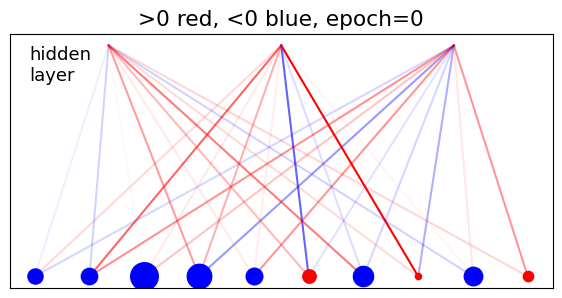

In [5]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)

(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0, w=w, a=a, b=b, CD=0):
    fig, ax = plt.subplots(1,1 , figsize=(7, 3.3))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=300.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")

    if CD == 0:
        ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    else:
        ax.set_title(f'>0 red, <0 blue, epoch={epoch}, CD={CD}')
    ax.text(-0.51,0.85,"hidden\nlayer")
    plt.show()
                  
plotgraph()

Transparency is associated to the strenght of the weights.

### Activation function with sigmoid


In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False): # v_in could be also the hidden one, info=True to print out something
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input =', v_in)
        print('act =',act)
        print('prob =',prob) # probabilities to have a 1 in the hidden units (before training)
        print('output =',v_out)
    return v_out

k = 0
print('input shape', v[k].shape)
print('weight matrix shape:', w.shape)
activate(v[k],w,b,GAP,info=True) # the output is an array of hidden units activated according to probabilities

input shape (10,)
weight matrix shape: (10, 3)
input = [0 0 1 1 0 0 0 0 1 1]
act = [0.71335964 0.78434445 0.62083422]
prob = [0.67114309 0.68661569 0.65040826]
output = [1 1 0]


array([1, 1, 0])

## RBM train


In [9]:
# random seed for reproducibility
np.random.seed(12345)

# contrastive divergence
CD_n = True
CD_n_steps = 1

# training function
def RBM_train(weights = w, a_func = a, b_func = b, verbose=False):

    # visualize initialized RBM
    if verbose:
        plotgraph(0)

    # learning rate
    l_rate = 1.0

    # minibatch, counter m that ranges from 0 to 500
    mini, m = 500, 0

    for epoch in range(100):
        # aggregate normalization of batch statistics and learning rate in l_rate_m
        l_rate_m = l_rate / mini
        for k in range(N): # running over the full dataset
            if m==0: # start of the minibatch
                # initialize averages in miniblock
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model= np.zeros((L,M)), np.zeros((L,M))

            # positive CD phase: generating h 
            h = activate(v[k],weights,b_func,GAP)
            # negative CD phase: generating fantasy vf
            vf = activate(h,weights.T,a_func,GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,weights,b_func,GAP)

            # contrastive divergence steps
            if CD_n:
                step = CD_n_steps - 1
                while step > 0:
                    vf = activate(hf,weights.T,a_func,GAP)
                    hf = activate(vf,weights,b_func,GAP)
                    step = step - 1

            # updating sum variables
            v_data  += v[k]
            v_model += vf
            h_data  += h
            h_model += hf
            vh_data += np.outer(v[k].T,h)
            vh_model+= np.outer(vf.T,hf)
        
            # updating minibatch internal counter
            m += 1

            # minibatch end
            if m==mini:
                # gradient of the likelihood: follow it along its positive direction
                # with a "vanilla" SGD
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
                if epoch<=1 and k<=mini:
                    if verbose:
                        print('----------- epoch =',epoch,'  k =',k,'  m =',m)
                        print('dw =',dw)
                        print('da =',da)
                        print('db =',db)
                # basic step of vanilla gradient descent, from eq.(211)
                weights = weights + dw
                a_func = a_func + da
                b_func = b_func + db
                m=0
        
        # calculate likelihood
        

        # randomize the order of input data at each epoch
        np.random.shuffle(v)
        # decrease the learning rate (here as a power law)
        l_rate = l_rate / (0.01 * l_rate + 1)
        if epoch%10==9:
            if verbose:
                plotgraph(epoch+1, w=weights, a=a_func, b=b_func)
                print('l_rate = ',l_rate)

    return (weights, a_func, b_func)

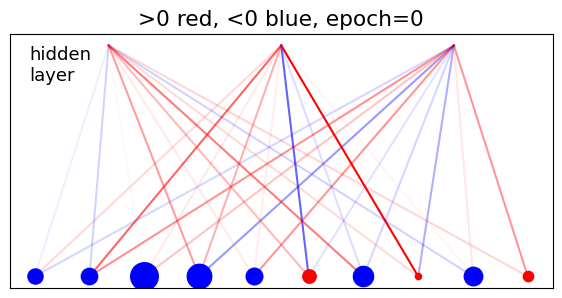

----------- epoch = 0   k = 499   m = 500
dw = [[ 0.124  0.066  0.082]
 [-0.078 -0.19  -0.09 ]
 [ 0.186  0.144  0.108]
 [ 0.094  0.074  0.072]
 [-0.022 -0.102 -0.036]
 [ 0.138  0.046  0.062]
 [ 0.08  -0.026  0.024]
 [-0.126 -0.23  -0.236]
 [ 0.12   0.09   0.096]
 [-0.124 -0.148 -0.12 ]]
da = [ 0.13  -0.154  0.208  0.124 -0.058  0.132  0.076 -0.258  0.146 -0.186]
db = [ 0.06  -0.084 -0.036]
----------- epoch = 1   k = 499   m = 500
dw = [[-0.01782178 -0.01782178 -0.01980198]
 [ 0.03960396 -0.04356436  0.00792079]
 [ 0.01386139  0.         -0.0950495 ]
 [-0.0039604  -0.07128713 -0.05742574]
 [-0.01386139 -0.04158416 -0.02772277]
 [ 0.01386139 -0.00792079 -0.03366337]
 [ 0.         -0.03762376 -0.02376238]
 [ 0.04356436  0.         -0.0039604 ]
 [-0.01980198 -0.04752475 -0.02376238]
 [-0.0039604  -0.0039604  -0.04158416]]
da = [ 0.01584158  0.03168317 -0.01188119 -0.04752475 -0.00990099  0.03168317
  0.01188119  0.02970297 -0.02772277 -0.00990099]
db = [ 0.01188119 -0.04554455 -0.04752475

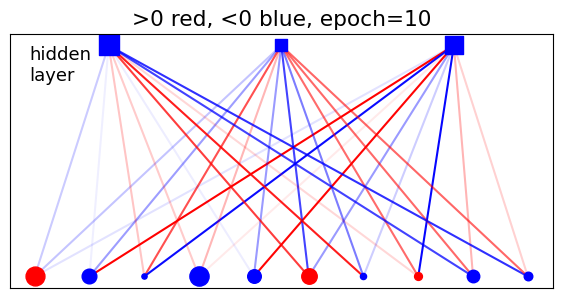

l_rate =  0.9090909090909092


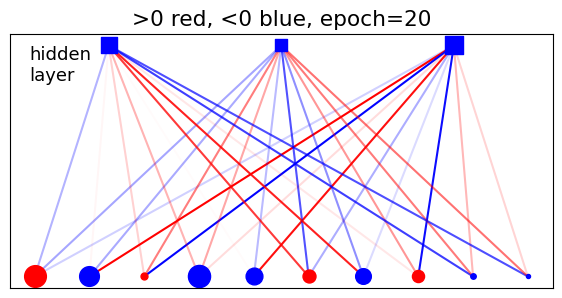

l_rate =  0.8333333333333337


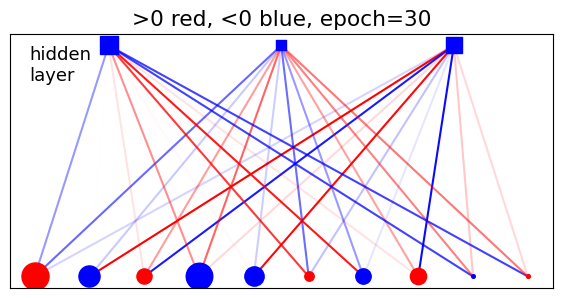

l_rate =  0.7692307692307697


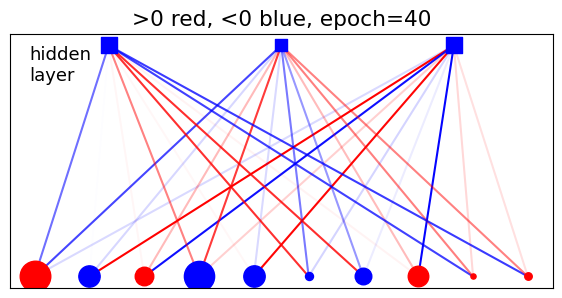

l_rate =  0.7142857142857149


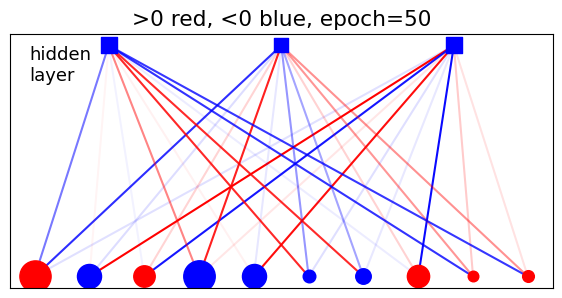

l_rate =  0.6666666666666671


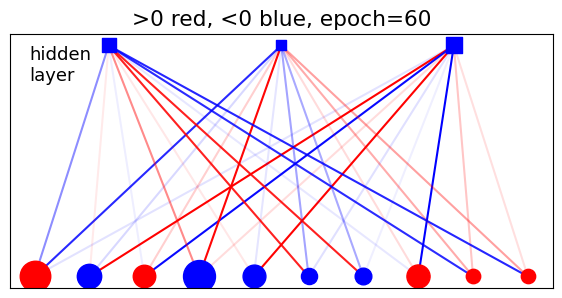

l_rate =  0.6250000000000006


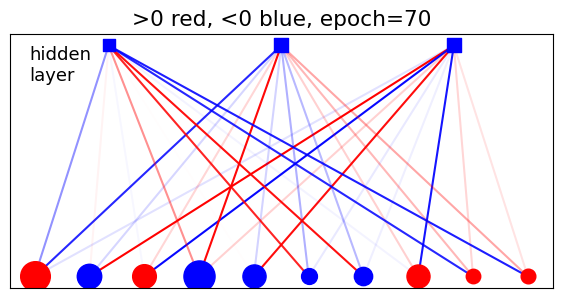

l_rate =  0.5882352941176475


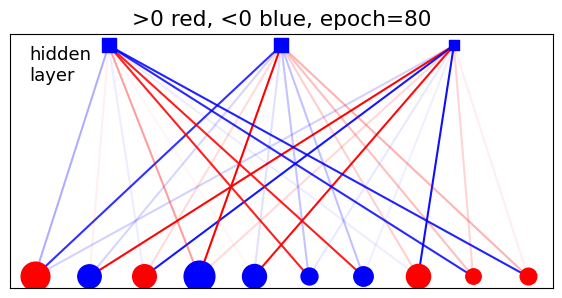

l_rate =  0.555555555555556


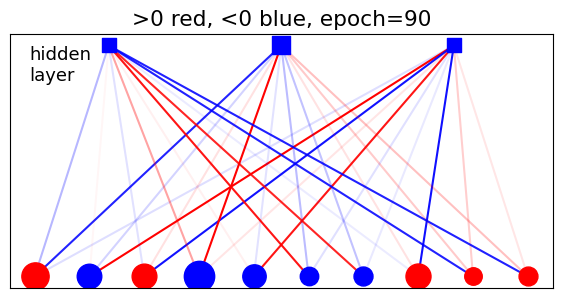

l_rate =  0.5263157894736847


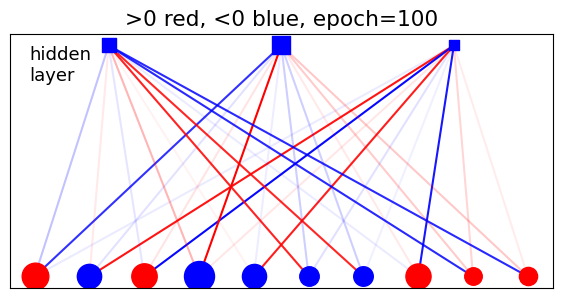

l_rate =  0.5000000000000009


In [8]:
training_results = RBM_train(verbose=True)

The colors tells us the kind of correlation between inputs. We impose a stochastic structure in visible layer through hidden variables. 

In [10]:
print('Initial weights:')
print('w0 =',w0);print('a0 =',a0);print('b0 =',b0)
print('\nFinal weights:')
print('w =',training_results[0]);print('a =',training_results[1]);print('b =',training_results[2])

Initial weights:
w0 = [[-1.13551379e-01  2.65669964e-01 -2.88132757e-01]
 [-3.08263709e-01  1.09041887e+00  7.72922489e-01]
 [ 5.15360175e-02  1.56284646e-01  4.26576969e-01]
 [ 6.91397593e-01  5.58688134e-01 -7.19014104e-01]
 [ 1.52537913e-01  1.26978019e-01  7.50463234e-01]
 [ 4.91702529e-01 -1.11030861e+00 -2.06261128e-01]
 [ 9.25808667e-01 -2.43274719e-01 -2.99394686e-01]
 [ 2.64583679e-01  1.80218983e+00 -5.66475108e-01]
 [-3.20110440e-01  6.88500960e-02  1.67859802e-01]
 [ 2.90536469e-01  5.21572266e-04  7.45411556e-01]]
a0 = [-0.39580299 -0.46104103 -1.31476796 -1.03216437 -0.4774623   0.3107127
 -0.70221411  0.06646813 -0.58993056  0.18465011]
b0 = [0. 0. 0.]

Final weights:


NameError: name 'training_results' is not defined

## Test: noise reduction

In [10]:
ampl=40.

# original, non-reshuffled data in v0
v1 = np.zeros_like(v0)
for k in range(N):
    # positive CD phase: generating h 
    h = activate(v0[k],training_results[0],training_results[2],ampl*GAP)
    # negative CD phase: generating fantasy vf with low T == large GAP
    v1[k] = activate(h,training_results[0].T,training_results[1],ampl*GAP)
    
# difference between fantasy and data
minib_size = 500
diff = (v1 - v0)/2
str0 = fname+'_M'+str(M)+'-mini'+str(minib_size)
np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  

N1=12
df0 = pd.DataFrame(v0[:N1])
df1 = pd.DataFrame(((v1[:N1]-vmin)/(1-vmin)).astype(int))

df0s = df0.style.set_table_attributes("style='display:inline'")
df1s = df1.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
df1s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)
df1s.set_caption('Low Temperature').set_table_styles(sty)

display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)

,0,1,2,3,4,5,6,7,8,9
0,0,0,1,1,0,0,0,0,1,1
1,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,1,0,1,0,0,0
3,0,1,1,1,0,1,0,1,0,0
4,1,1,1,0,1,1,1,1,0,0
5,0,1,0,0,1,1,1,0,0,0
6,1,0,1,0,0,0,1,1,1,1
7,1,0,1,1,0,1,1,0,0,0
8,1,0,1,0,0,0,0,1,1,1
9,1,1,0,0,1,1,0,0,0,0


Low temperature: the sigmoid becomes like a step function and the patterns become clearer.

### 1. Increase the number of CD (contrastive divergence) step from $n=1$ to $n=5$.

In [13]:
for i in range(1,6):
    w_CD, a_CD, b_CD = RBM_train()
    plotgraph(epoch=100, w=w_CD, a=a_CD, b=b_CD, CD=i)

NameError: name 'RBM_train' is not defined

### 2. Compute the log-likelihood during the training, at every epoch, or every minibatch update if it reaches a maximum already in the first epoch. Use 't' as an index of this 'time', indicating the unit in the figures.

To compute the likelihood, consider full configurations $x = (v,h)$ and their energy $E(x)$. With $L$ visible units and $M$ hidden units, we have $2^{L+M}$ possible configurations. 

The **partition function $Z$** is the sum of all the Boltzmann weights $e^{-E(x)}$ of all the possible configurations. 

The **average expectation of the energy according to data** is computed by averaging the energy of each data sample $v_n$ completed with all $2^M$ possible hidden states. Thus, in total there are $N*2^M$ configurations to use in the $<E>_{data}$ average.

In [20]:
import itertools as it

# get all the possible configurations
def get_config(Q):
    conf = it.product((0,1), repeat=Q)
    conf = list(conf)
    return np.array(conf)

In [16]:
# all configurations between visible and hidden variables
all_conf = get_config(L+M)

# alla configurations of hidden variables
all_conf_hid = get_config(M)

In [17]:
# useful functions to compute the likelihood

# energy average
def energy(vis,hid,weights,a_func,b_func):
    return (-np.dot(a_func, vis) - np.dot(b_func, hid) - np.dot(np.dot(vis, weights),hid))

# partition function Z
def part_func_Z(weights, a_func, b_func):
    boltz_w = []
    for c in all_conf:
        v = c[:L]
        h = c[L:]
        boltz_w.append(np.exp(- energy(v, h, weights, a_func, b_func)))
    return np.sum(np.array(boltz_w))

# average expectation of the energy according to data
def av_energy_data(vk, weights, a_func, b_func):
    e = []
    for c in all_conf_hid:
        e.append(energy(vk, c, weights, a_func, b_func))
    return np.sum(np.array(e))/(2**M)

In [9]:
def RBM_train_L(weights = w, a_func = a, b_func = b, verbose=False):

    # visualize initialized RBM
    if verbose:
        plotgraph(0)

    # learning rate
    l_rate = 1.0

    # minibatch, counter m that ranges from 0 to 500
    mini, m = 500, 0

    # likelihood over epochs
    lik = []
    data_energies = []
    logZs = []

    for epoch in range(150):
        # aggregate normalization of batch statistics and learning rate in l_rate_m
        l_rate_m = l_rate / mini
        energies = []
        for k in range(N): # running over the full dataset
            if m==0: # start of the minibatch
                # initialize averages in miniblock
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model= np.zeros((L,M)), np.zeros((L,M))

            # positive CD phase: generating h 
            h = activate(v[k],weights,b_func,GAP)
            # negative CD phase: generating fantasy vf
            vf = activate(h,weights.T,a_func,GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,weights,b_func,GAP)

            # contrastive divergence steps
            if CD_n:
                step = CD_n_steps - 1
                while step > 0:
                    vf = activate(hf,weights.T,a_func,GAP)
                    hf = activate(vf,weights,b_func,GAP)
                    step = step - 1

            # updating sum variables
            v_data  += v[k]
            v_model += vf
            h_data  += h
            h_model += hf
            vh_data += np.outer(v[k].T,h)
            vh_model+= np.outer(vf.T,hf)
        
            # updating minibatch internal counter
            m += 1

            # minibatch end
            if m==mini:
                # gradient of the likelihood: follow it along its positive direction
                # with a "vanilla" SGD
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
                if epoch<=1 and k<=mini:
                    if verbose:
                        print('----------- epoch =',epoch,'  k =',k,'  m =',m)
                        print('dw =',dw)
                        print('da =',da)
                        print('db =',db)
                # basic step of vanilla gradient descent, from eq.(211)
                weights = weights + dw
                a_func = a_func + da
                b_func = b_func + db
                m=0

            #ek = av_energy_data(v[k], weights, a_func, b_func)
            #energies.append(ek)
            num = np.sum([energy(v[k], h_i, weights, a_func, b_func) * np.exp(-energy(v[k], h_i, weights, a_func, b_func)) for h_i in all_conf_hid])
            den = np.sum([np.exp(-energy(v[k], h_i, weights, a_func, b_func)) for h_i in all_conf_hid])
            energies.append(num/den)
        
        # calculate likelihood
        fZ = np.log(part_func_Z(weights, a_func, b_func))
        ee = np.mean(energies) # np.sum(np.array(energies))/N
        l = - ee - fZ
        lik.append(l)
        data_energies.append(ee)
        logZs.append(fZ)
        print('Epoch:', epoch, '\tLikelihood:', l)

        # randomize the order of input data at each epoch
        np.random.shuffle(v)
        # decrease the learning rate (here as a power law)
        l_rate = l_rate / (0.01 * l_rate + 1)
        if epoch%10==9:
            if verbose:
                plotgraph(epoch+1, w=weights, a=a_func, b=b_func)
                print('l_rate = ',l_rate)

    return (weights, a_func, b_func, lik, data_energies, logZs)

In [16]:
w_l, a_l, b_l, logL, dataenergies, logZfunc = RBM_train_L()

Epoch: 0 	Likelihood: -8.626686949083178
Epoch: 1 	Likelihood: -8.631477442940948
Epoch: 2 	Likelihood: -8.102063203549406
Epoch: 3 	Likelihood: -8.052374592175001
Epoch: 4 	Likelihood: -7.723218913077599
Epoch: 5 	Likelihood: -7.837349832249057
Epoch: 6 	Likelihood: -7.734290159271325
Epoch: 7 	Likelihood: -8.175902376115708
Epoch: 8 	Likelihood: -7.779771757918527
Epoch: 9 	Likelihood: -7.729498689976893
Epoch: 10 	Likelihood: -7.971779351592846
Epoch: 11 	Likelihood: -7.760548032237134
Epoch: 12 	Likelihood: -7.784386797088925
Epoch: 13 	Likelihood: -7.933027700389664
Epoch: 14 	Likelihood: -7.868553441090873
Epoch: 15 	Likelihood: -7.814293107454368
Epoch: 16 	Likelihood: -7.703648343213956
Epoch: 17 	Likelihood: -7.821517084383315
Epoch: 18 	Likelihood: -7.87344079005365
Epoch: 19 	Likelihood: -7.636017563426426
Epoch: 20 	Likelihood: -7.712000981960791
Epoch: 21 	Likelihood: -8.014797882038406
Epoch: 22 	Likelihood: -7.7102319976415945
Epoch: 23 	Likelihood: -7.797239120752602
Ep

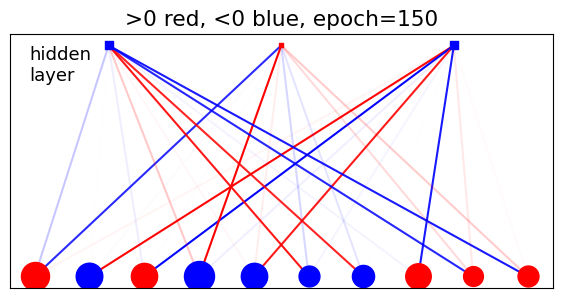

In [17]:
plotgraph(150, w_l, a_l, b_l)

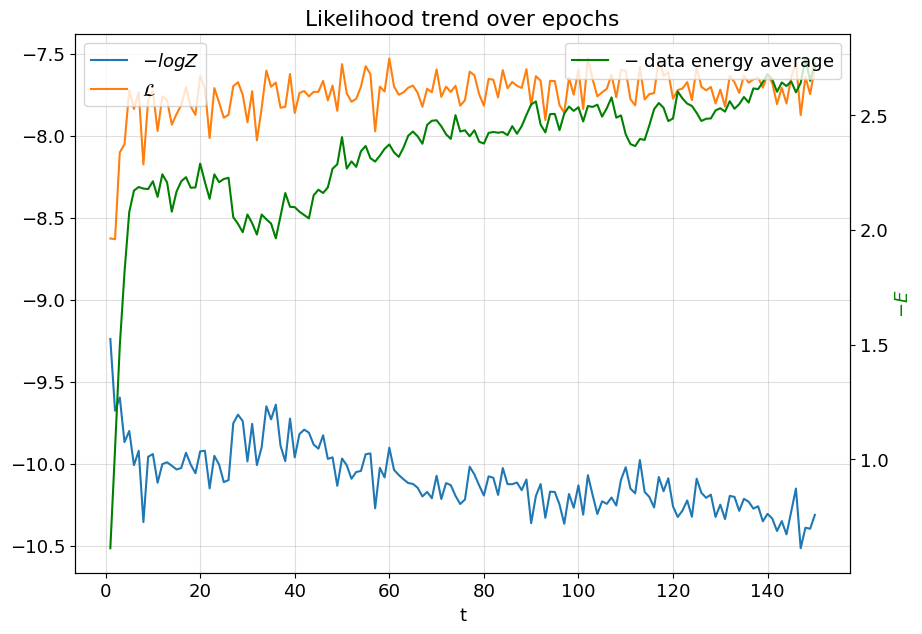

In [18]:
# plot log likelihood during training

logZfunc_ = (-1)*np.array(logZfunc)

fig, ax = plt.subplots(figsize=(10,7))
ax.grid(alpha=0.4)

eps = np.linspace(1, len(logL), len(logL))

ax1 = ax.twinx()
ax1.plot(eps, (-1)*np.array(dataenergies), label = '$-$ data energy average', color = 'green')
ax.plot(eps, logZfunc_, label = '$-logZ$')
ax.plot(eps, logL, label = '$\\mathcal{L}$')
ax.set_xlabel('t')
ax.set_title('Likelihood trend over epochs')
ax.legend(loc='upper left')
#ax.set_ylim(-12.7,-9.5)
# ax1.set_ylim(-0.3,0.7)
ax1.legend(loc='upper right')
ax1.set_ylabel('$-E$', color = 'green')

plt.show()

### 3. For M=3, plot the likelihood as a function of 't', comparing the two contrastive divergence cases ($n=1$ and $n=5$). Then, for $n=1$, plot the likelihood as a function of 't', comparing the two cases with different $M$.

### 4. From the weights learned by the RBM, guess the structure of the data.

### 5. Try RBMs with different numbers of hidden units: $M=1,2,3,4,5,6.$

In [7]:
# RBM, nr of hidden units
M = 5
# range of each initial weight
sigma = sqrt(4. / float(L + M)) # std dev of the initial weights in the layers
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M) # interaction matrix
a = sigma * np.random.randn(L) 
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

w= [[-1.05710581e-01  2.47325276e-01 -2.68236999e-01 -2.86977895e-01
   1.01512472e+00]
 [ 7.19551678e-01  4.79774212e-02  1.45493088e-01  3.97121546e-01
   6.43656130e-01]
 [ 5.20110348e-01 -6.69365702e-01  1.42005069e-01  1.18210102e-01
   6.98643250e-01]
 [ 4.57750143e-01 -1.03364106e+00 -1.92018661e-01  8.61880964e-01
  -2.26476438e-01]
 [-2.78721284e-01  2.46314000e-01  1.67774743e+00 -5.27359626e-01
  -2.98006602e-01]
 [ 6.40959511e-02  1.56268971e-01  2.70474733e-01  4.85557355e-04
   6.93940393e-01]
 [-3.68472529e-01 -4.29205842e-01 -1.22398236e+00 -9.60892739e-01
  -4.44493209e-01]
 [ 2.89257786e-01 -6.53725760e-01  6.18784611e-02 -5.49195467e-01
   1.71899895e-01]
 [-1.21839863e+00 -1.03043539e-01 -7.96283067e-01 -5.01285870e-01
  -6.74947519e-01]
 [ 1.47870374e-01  1.95190156e-01 -3.89305333e-01  1.71075174e-01
   6.97003882e-01]]
a= [ 0.03608417  0.12738196 -0.0061253   0.51888247  0.68536035 -0.47470463
 -0.79995512  0.01145608  0.39161704 -0.3410933 ]
b= [0. 0. 0. 0. 0.]


In [14]:
# all configurations between visible and hidden variables
all_conf = get_config(L+M)

# alla configurations of hidden variables
all_conf_hid = get_config(M)

NameError: name 'get_config' is not defined

In [15]:
CD_n = True
CD_n_steps = 1
def RBM_train_L(weights , a_func , b_func , verbose=False):

    print(M)
    # visualize initialized RBM
    if verbose:
        plotgraph(0)

    # learning rate
    l_rate = 1.0

    # minibatch, counter m that ranges from 0 to 500
    mini, m = 500, 0

    # likelihood over epochs
    lik = []
    data_energies = []
    logZs = []

    for epoch in range(100):
        # aggregate normalization of batch statistics and learning rate in l_rate_m
        l_rate_m = l_rate / mini
        energies = []
        for k in range(N): # running over the full dataset
            if m==0: # start of the minibatch
                # initialize averages in miniblock
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model= np.zeros((L,M)), np.zeros((L,M))

            # positive CD phase: generating h 
            h = activate(v[k],weights,b_func,GAP)
            # negative CD phase: generating fantasy vf
            vf = activate(h,weights.T,a_func,GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,weights,b_func,GAP)

            # contrastive divergence steps
            if CD_n:
                step = CD_n_steps - 1
                while step > 0:
                    vf = activate(hf,weights.T,a_func,GAP)
                    hf = activate(vf,weights,b_func,GAP)
                    step = step - 1

            # updating sum variables
            v_data  += v[k]
            v_model += vf
            h_data  += h
            h_model += hf
            vh_data += np.outer(v[k].T,h)
            vh_model+= np.outer(vf.T,hf)
        
            # updating minibatch internal counter
            m += 1

            # minibatch end
            if m==mini:
                # gradient of the likelihood: follow it along its positive direction
                # with a "vanilla" SGD
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
                if epoch<=1 and k<=mini:
                    if verbose:
                        print('----------- epoch =',epoch,'  k =',k,'  m =',m)
                        print('dw =',dw)
                        print('da =',da)
                        print('db =',db)
                # basic step of vanilla gradient descent, from eq.(211)
                weights = weights + dw
                a_func = a_func + da
                b_func = b_func + db
                m=0

            #ek = av_energy_data(v[k], weights, a_func, b_func)
            #energies.append(ek)
            num = np.sum([energy(v[k], h_i, weights, a_func, b_func) * np.exp(-energy(v[k], h_i, weights, a_func, b_func)) for h_i in all_conf_hid])
            den = np.sum([np.exp(-energy(v[k], h_i, weights, a_func, b_func)) for h_i in all_conf_hid])
            energies.append(num/den)
        
        # calculate likelihood
        fZ = np.log(part_func_Z(weights, a_func, b_func))
        ee = np.mean(energies) # np.sum(np.array(energies))/N
        l = - ee - fZ
        lik.append(l)
        data_energies.append(ee)
        logZs.append(fZ)
        print('Epoch:', epoch, '\tLikelihood:', l)

        # randomize the order of input data at each epoch
        np.random.shuffle(v)
        # decrease the learning rate (here as a power law)
        l_rate = l_rate / (0.01 * l_rate + 1)
        if epoch%10==9:
            if verbose:
                plotgraph(epoch+1, w=weights, a=a_func, b=b_func)
                print('l_rate = ',l_rate)
    return (weights, a_func, b_func, lik, data_energies, logZs)

In [16]:
training_loop = []
for M in range(1,7):
    print(f'------RBM model with {M} hidden layer------')

    sigma = sqrt(4. / float(L + M)) 
    np.random.seed(12345)
    wloop = sigma * np.random.randn(L,M)
    aloop = sigma * np.random.randn(L) 
    bloop = np.zeros(M)
    w0,a0,b0=np.copy(wloop),np.copy(aloop),np.copy(bloop)
    
    all_conf = get_config(L+M)
    all_conf_hid = get_config(M)

    w_loop, a_loop, b_loop, logL_loop, dataenergies_loop, logZfunc_loop = RBM_train_L(weights=wloop, a_func=aloop, b_func=bloop)
    training_loop.append([w_loop, a_loop, b_loop, logL_loop, dataenergies_loop, logZfunc_loop])

------RBM model with 1 hidden layer------
1
Epoch: 0 	Likelihood: -7.460786074114847
Epoch: 1 	Likelihood: -7.562133878181398
Epoch: 2 	Likelihood: -7.321065343845414
Epoch: 3 	Likelihood: -7.2045908750474865
Epoch: 4 	Likelihood: -7.010791982709022


KeyboardInterrupt: 

In [ ]:
import pandas as pd

In [36]:
prova = pd.DataFrame(training_loop)
prova

,0,1,2,3,4,5
0,"[[-0.006737564286505945], [2.2702870733575526]...","[-0.04096891421366455, -1.1262597351184245, 1....",[-0.13366858223051054],"[-7.396191535887891, -7.464744270957588, -7.43...","[-0.1281432669900031, -0.15461715404469922, -0...","[7.5243348028778945, 7.619361425002288, 7.7856..."
1,"[[-0.01701769253660177, 0.03367236232559783], ...","[-0.008051475284188796, -1.0790593217130846, 1...","[0.06101793175032803, -0.10854124012792131]","[-7.780192398957094, -8.050564562684169, -8.13...","[-0.28874962471137783, -0.22450318736061914, -...","[8.068942023668471, 8.275067750044789, 8.63107..."
2,"[[-0.6980726918448156, -2.2163210880769504, -0...","[1.422617663369708, -0.992708174941841, 1.0161...","[-0.2519297784752961, -0.42874355564806366, -0...","[-8.84467811177744, -8.36197311666945, -8.1467...","[-0.3608745307926233, -0.8540442526440895, -1....","[9.205552642570064, 9.216017369313539, 9.31897..."
3,"[[1.8097116544000127, 0.12535988649037205, -0....","[-0.6488135826289166, 0.15351483422573622, -0....","[-0.2592876786509585, 0.11743423167019199, -0....","[-9.137298979831426, -8.831678295600886, -8.88...","[-0.38367624175501086, -0.6251258204564619, -1...","[9.520975221586436, 9.456804116057349, 10.0839..."
4,"[[-0.23960726335941998, 0.8278973061573304, -0...","[-0.3336147553639, -0.39970817344452425, 0.651...","[0.1277117589045262, -0.004205245163301428, -1...","[-9.830554947905004, -9.390271465378921, -9.34...","[-0.2369750724139442, -0.8885158014149721, -1....","[10.067530020318948, 10.278787266793893, 10.77..."
5,"[[0.03163758753163884, -1.228348369742485, 0.2...","[-0.873249067279671, -0.018031617531203997, -0...","[0.08907470685117254, -0.3363159530665869, 0.2...","[-10.420270057742286, -10.323586714139886, -9....","[-0.14296547479362626, -0.3919681867526405, -0...","[10.563235532535913, 10.715554900892526, 10.65..."


In [38]:
training_loop[0][3]

[-7.396191535887891,
 -7.464744270957588,
 -7.436486942207196,
 -7.104101643773199,
 -7.041041457432254,
 -7.032624347792103,
 -7.014643186625314,
 -7.097091730947376,
 -7.1776686129888505,
 -6.969384022829562,
 -7.098889056742424,
 -7.0576927248031875,
 -6.990094660382224,
 -6.935650113684258,
 -7.113184988848068,
 -7.080697238701677,
 -7.121955890198706,
 -7.16167057314642,
 -7.19459658628559,
 -7.0269063320605545,
 -7.106733165015214,
 -6.918368658670184,
 -7.05423294608465,
 -6.989207460800604,
 -6.914096056035227,
 -7.201099848038694,
 -7.035840898022332,
 -7.095769527091445,
 -7.062838922215419,
 -7.114645130313182,
 -7.120662297616462,
 -7.108623065387413,
 -7.076701050104626,
 -7.032072417768402,
 -7.078201129687789,
 -7.075537412217523,
 -7.1896151347368935,
 -7.062190320301079,
 -6.905443233805285,
 -7.111422807237342,
 -6.948487307576876,
 -7.1156021080341745,
 -7.095095584473843,
 -7.102889117182838,
 -7.105635912371465,
 -6.991177454530424,
 -7.141015000247123,
 -7.0847905

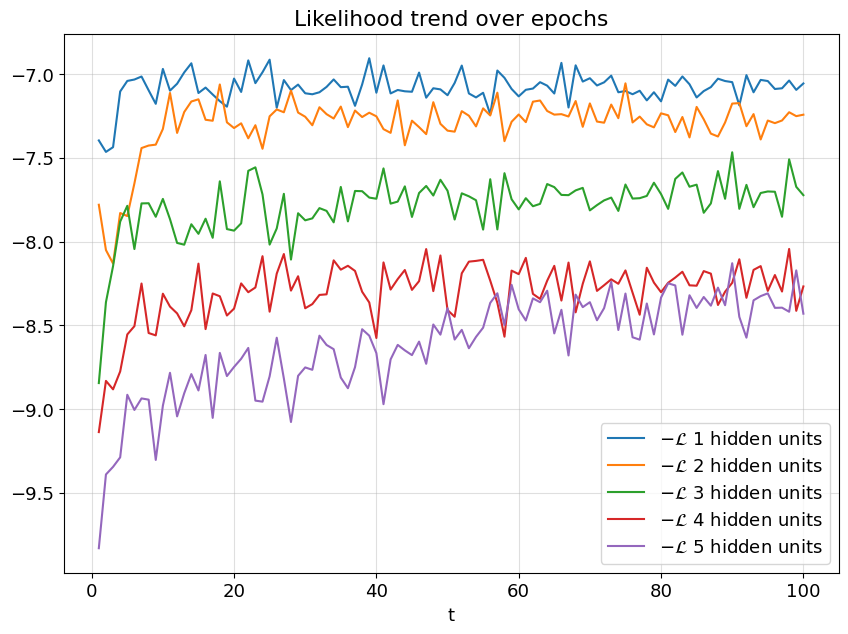

In [50]:
# plot log likelihood during training

#logZfunc_ = (-1)*np.array(logZfunc)

fig, ax = plt.subplots(figsize=(10,7))
ax.grid(alpha=0.4)

eps = np.arange(1, 101, 1)

#ax1 = ax.twinx()
#ax1.plot(eps, (-1)*np.array(dataenergies), label = '$-$ data energy average', color = 'green')
ax.plot(eps, training_loop[0][3] , label = '$-\\mathcal{L}$ 1 hidden units')
ax.plot(eps, training_loop[1][3] , label = '$-\\mathcal{L}$ 2 hidden units')
ax.plot(eps, training_loop[2][3] , label = '$-\\mathcal{L}$ 3 hidden units')
ax.plot(eps, training_loop[3][3] , label = '$-\\mathcal{L}$ 4 hidden units')
ax.plot(eps, training_loop[4][3] , label = '$-\\mathcal{L}$ 5 hidden units')
#ax.plot(eps, logL, label = '$\\mathcal{L}$')
ax.set_xlabel('t')
ax.set_title('Likelihood trend over epochs')
ax.legend(loc='lower right')
#ax.set_ylim(-12.7,-9.5)
# ax1.set_ylim(-0.3,0.7)
#ax1.legend(loc='upper right')
#ax1.set_ylabel('$-E$', color = 'green')

plt.show()

# Same but with validation set 

In [51]:
# redefinition of the training function adding the validation metrics 

In [10]:
N_train =  round(0.75*N) 
train_data = v[:N_train]
validation_data = v[N_train:]


In [95]:
CD_n = True
CD_n_steps = 1
def RBM_train_validation_L(beta1, beta2,weights , a_func , b_func , verbose=False, lambda_reg= 0.1):
    
    print(M)
    # visualize initialized RBM
    if verbose:
        plotgraph(0)

    # learning rate
    l_rate = 20.0

    # minibatch, counter m that ranges from 0 to 500
    mini, m = 500, 0

    # likelihood over epochs
    train_lik = []
    validation_lik = []
    train_data_energies = []
    validation_data_energies = []
    train_logZs = []

    for epoch in range(120):
        # aggregate normalization of batch statistics and learning rate in l_rate_m
        l_rate_m = l_rate / mini
        train_energies = []
        validation_energies = []
        for k in range(N_train): # running over the full dataset
            if m==0: # start of the minibatch
                # initialize averages in miniblock
                v_data_train, v_model_train = np.zeros(L), np.zeros(L)
                h_data_train, h_model_train = np.zeros(M), np.zeros(M)
                vh_data_train, vh_model_train = np.zeros((L,M)), np.zeros((L,M))
                if epoch==0 :
                    mtw=0.0
                    stw=0.0
                    mta=0.0
                    mtb=0.0
                    sta=0.0
                    stb=0.0
            # positive CD phase: generating h 
            h = activate(train_data[k],weights,b_func,GAP)
            # negative CD phase: generating fantasy vf
            vf = activate(h,weights.T,a_func,GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,weights,b_func,GAP)

            # contrastive divergence steps
            if CD_n:
                step = CD_n_steps - 1
                while step > 0:
                    vf = activate(hf,weights.T,a_func,GAP)
                    hf = activate(vf,weights,b_func,GAP)
                    step = step - 1

            # updating sum variables
            v_data_train   += v[k]
            v_model_train  += vf
            h_data_train   += h
            h_model_train  += hf
            vh_data_train  += np.outer(v[k].T,h)
            vh_model_train += np.outer(vf.T,hf)
        
            # updating minibatch internal counter
            m += 1

            # minibatch end
            if m==mini:
                # gradient of the likelihood: follow it along its positive direction
                # with a "vanilla" SGD
                gw=vh_data_train - vh_model_train-2*lambda_reg*np.sum(np.array(weights))
                mtw=beta1*mtw+(1-beta1)*gw
                stw=beta2*stw+(1-beta2)*gw**2
                mtw_cap=mtw/(1-(beta1)**(epoch+1))
                stw_cap=stw/(1-(beta2)**(epoch+1))

                ga=v_data_train - v_model_train
                mta=beta1*mta+(1-beta1)*ga
                sta=beta2*sta+(1-beta2)*ga**2
                mta_cap=mta/(1-(beta1)**(epoch+1))
                sta_cap=sta/(1-(beta2)**(epoch+1))


                gb=h_data_train - h_model_train
                mtb=beta1*mtb+(1-beta1)*gb
                stb=beta2*stb+(1-beta2)*gb**2
                mtb_cap=mtb/(1-(beta1)**(epoch+1))
                stb_cap=stb/(1-(beta2)**(epoch+1))
                
                dw = l_rate_m*(mtw_cap/(np.sqrt(stw_cap)+10**(-8)))
                da = l_rate_m*(mta_cap/(np.sqrt(sta_cap)+10**(-8)))
                db = l_rate_m*(mtb_cap/(np.sqrt(stb_cap)+10**(-8)))


                if epoch<=1 and k<=mini:
                    if verbose:
                        print('----------- epoch =',epoch,'  k =',k,'  m =',m)
                        print('dw =',dw)
                        print('da =',da)
                        print('db =',db)
                # basic step of vanilla gradient descent, from eq.(211)
                weights = weights + dw
                a_func = a_func + da
                b_func = b_func + db
                m=0

            #ek = av_energy_data(v[k], weights, a_func, b_func)
            #energies.append(ek)
            num = np.sum([energy(train_data[k], h_i, weights, a_func, b_func) * np.exp(-energy(train_data[k], h_i, weights, a_func, b_func)) for h_i in all_conf_hid])
            den = np.sum([np.exp(-energy(train_data[k], h_i, weights, a_func, b_func)) for h_i in all_conf_hid])
            train_energies.append(num/den)
        
        for k_val in range(N-N_train):
            num_val = np.sum([energy(validation_data[k_val], h_i, weights, a_func, b_func) * np.exp(-energy(validation_data[k_val], h_i, weights, a_func, b_func)) for h_i in all_conf_hid])
            den_val = np.sum([np.exp(-energy(validation_data[k_val], h_i, weights, a_func, b_func)) for h_i in all_conf_hid])
            validation_energies.append(num_val/den_val)

        # calculate likelihood
        fZ = np.log(part_func_Z(weights, a_func, b_func))
        ee_train = np.mean(train_energies) # np.sum(np.array(energies))/N
        ee_val = np.mean(validation_energies)
        l_train = - ee_train - fZ + lambda_reg*np.sum([z**2 for z in weights])
        l_val = - ee_val - fZ + lambda_reg*np.sum([z**2 for z in weights])
        train_lik.append(l_train)
        validation_lik.append(l_val)
        train_data_energies.append(ee_train)
        validation_data_energies.append(ee_val)
        train_logZs.append(fZ)
        print('Epoch:', epoch, '\t Training Likelihood:', l_train, '\t Validation Likelihood:', l_val)
        # randomize the order of input data at each epoch
        np.random.shuffle(train_data)
        # decrease the learning rate (here as a power law)
        l_rate = l_rate / (0.01 * l_rate + 1)
        if epoch%10==9:
            if verbose:
                plotgraph(epoch+1, w=weights, a=a_func, b=b_func)
                print('l_rate = ',l_rate)
    return (weights, a_func, b_func, train_lik, validation_lik, train_data_energies, validation_data_energies, train_logZs)

In [96]:
training_loop = []
for M in range(1,7):
    print(f'------RBM model with {M} hidden layer------')

    sigma = sqrt(4. / float(L + M)) 
    np.random.seed(12345)
    wloop = sigma * np.random.randn(L,M)
    aloop = sigma * np.random.randn(L) 
    bloop = np.zeros(M)
    w0,a0,b0=np.copy(wloop),np.copy(aloop),np.copy(bloop)
    
    all_conf = get_config(L+M)
    all_conf_hid = get_config(M)

    w_loop, a_loop, b_loop, logL_loop_train, logL_loop_val,  dataenergies_loop_train, dataenergies_loop_val, logZfunc_loop_train = RBM_train_validation_L(0.9,0.999,weights=wloop, a_func=aloop, b_func=bloop)
    training_loop.append([w_loop, a_loop, b_loop, logL_loop_train, logL_loop_val,  dataenergies_loop_train, dataenergies_loop_val, logZfunc_loop_train])

------RBM model with 1 hidden layer------
1
Epoch: 0 	 Training Likelihood: -6.643281045358545 	 Validation Likelihood: -7.248241561953717
Epoch: 1 	 Training Likelihood: -6.971897526691624 	 Validation Likelihood: -6.927120144087081
Epoch: 2 	 Training Likelihood: -6.712043359635441 	 Validation Likelihood: -6.559447480416301
Epoch: 3 	 Training Likelihood: -6.303590873618197 	 Validation Likelihood: -6.303579781894407
Epoch: 4 	 Training Likelihood: -6.23395262597521 	 Validation Likelihood: -6.126471136369067
Epoch: 5 	 Training Likelihood: -6.0667871934102156 	 Validation Likelihood: -5.983080003746582
Epoch: 6 	 Training Likelihood: -5.9004660857023055 	 Validation Likelihood: -5.887815873235962
Epoch: 7 	 Training Likelihood: -5.808733472678535 	 Validation Likelihood: -5.813630037780876
Epoch: 8 	 Training Likelihood: -5.7684927399150805 	 Validation Likelihood: -5.738636325326489
Epoch: 9 	 Training Likelihood: -5.741222685783801 	 Validation Likelihood: -5.682799209766774
Epoc

In [97]:
#PALETTE 
col_1 = '#648FFF'
col_2 = '#785EF0'
col_3 = '#DC267F'
col_4 = '#FE6100'
col_5 = '#FFB000'

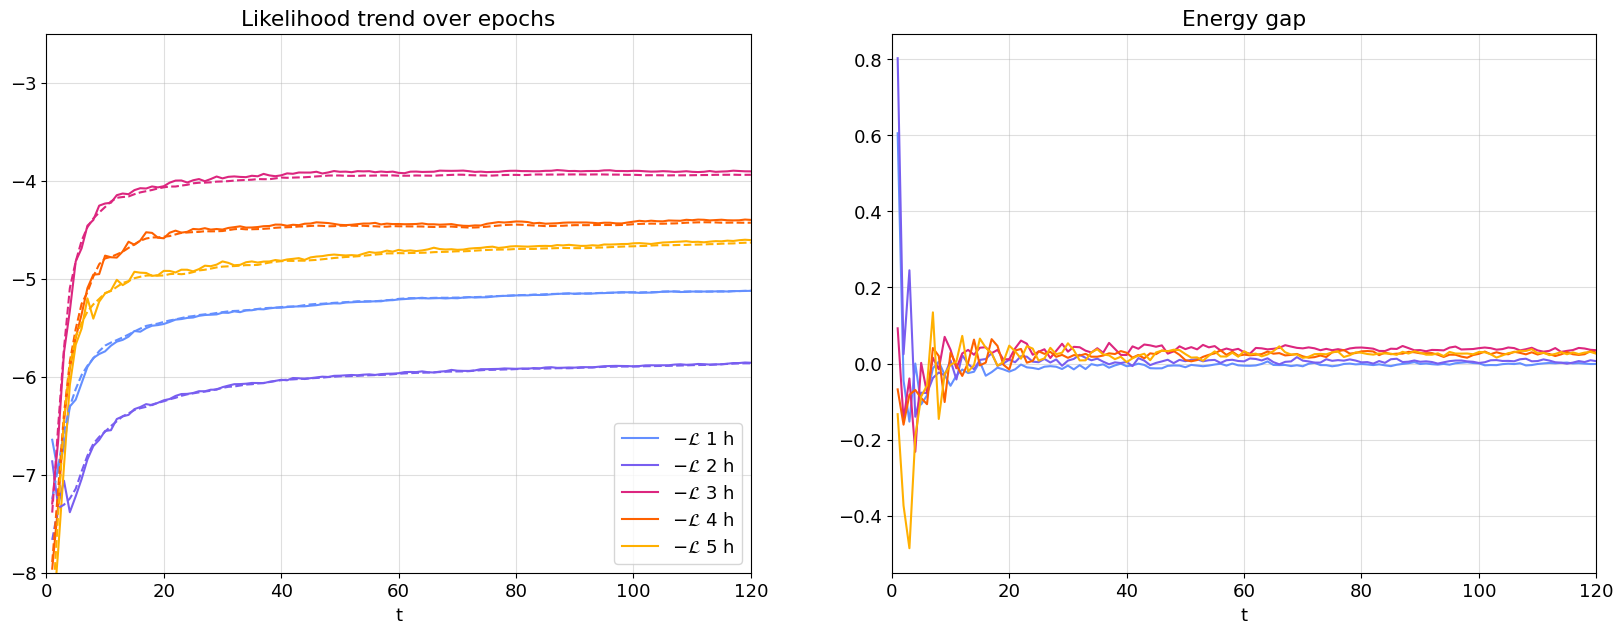

In [105]:
# plot log likelihood during training

#logZfunc_ = (-1)*np.array(logZfunc)

fig, ax = plt.subplots(1,2,figsize=(20,7))
ax[0].grid(alpha=0.4)
ax[1].grid(alpha=0.4)

eps = np.arange(1, 121, 1)

#ax1 = ax.twinx()
#ax1.plot(eps, (-1)*np.array(dataenergies), label = '$-$ data energy average', color = 'green')
ax[0].plot(eps, training_loop[0][3] , label = '$-\\mathcal{L}$ 1 h', color = col_1)
ax[0].plot(eps, training_loop[1][3] , label = '$-\\mathcal{L}$ 2 h', color = col_2)
ax[0].plot(eps, training_loop[2][3] , label = '$-\\mathcal{L}$ 3 h', color = col_3)
ax[0].plot(eps, training_loop[3][3] , label = '$-\\mathcal{L}$ 4 h', color = col_4)
ax[0].plot(eps, training_loop[4][3] , label = '$-\\mathcal{L}$ 5 h', color = col_5)
#ax.plot(eps, logL, label = '$\\mathcal{L}$')
ax[0].set_xlabel('t')
ax[0].set_title('Likelihood trend over epochs')
ax[0].legend(loc='lower right')
ax[0].set_ylim(-11.7,-6)
#ax.set_ylim(-12.7,-9.5)
# ax1.set_ylim(-0.3,0.7)
#ax1.legend(loc='upper right')
#ax1.set_ylabel('$-E$', color = 'green')
# plot log likelihood during training

#logZfunc_ = (-1)*np.array(logZfunc)

#ax1 = ax.twinx()
#ax1.plot(eps, (-1)*np.array(dataenergies), label = '$-$ data energy average', color = 'green')
ax[0].plot(eps, training_loop[0][4] , label = '$-\\mathcal{L}$ 1 h', linestyle = '--', color = col_1)
ax[0].plot(eps, training_loop[1][4] , label = '$-\\mathcal{L}$ 2 h', linestyle = '--', color = col_2)
ax[0].plot(eps, training_loop[2][4] , label = '$-\\mathcal{L}$ 3 h', linestyle = '--', color = col_3)
ax[0].plot(eps, training_loop[3][4] , label = '$-\\mathcal{L}$ 4 h', linestyle = '--', color = col_4)
ax[0].plot(eps, training_loop[4][4] , label = '$-\\mathcal{L}$ 5 h', linestyle = '--', color = col_5)#ax.plot(eps, logL, label = '$\\mathcal{L}$')
ax[0].set_xlim(0,120)
#ax[1].set_xlabel('t')
#ax[1].set_title('Likelihood trend over epochs')
#ax[1].legend(loc='lower right')
ax[0].set_ylim(-8,-2.5)
# ax1.set_ylim(-0.3,0.7)
#ax1.legend(loc='upper right')
#ax1.set_ylabel('$-E$', color = 'green')
ax[1].set_title('Energy gap')
ax[1].set_xlabel('t')
ax[1].plot(eps, (np.array(training_loop[0][6]) - np.array(training_loop[0][5])) , label = 'energy gap 1 hidden units', color = col_1)
ax[1].plot(eps, (np.array(training_loop[1][6]) - np.array(training_loop[1][5])) , label = 'energy gap 2 hidden units', color = col_2)
ax[1].plot(eps, (np.array(training_loop[2][6]) - np.array(training_loop[2][5])) , label = 'energy gap 3 hidden units', color = col_3)
ax[1].plot(eps, (np.array(training_loop[3][6]) - np.array(training_loop[3][5])) , label = 'energy gap 4 hidden units', color = col_4)
ax[1].plot(eps, (np.array(training_loop[4][6]) - np.array(training_loop[4][5])) , label = 'energy gap 5 hidden units', color = col_5)
ax[1].set_xlim(0,120)

plt.show()

plt.show()

In [70]:
a = np.array(training_loop[0][6])
a.shape

(2500,)